# Prédiction de la survie ou non des passagers du titanic

L'objectif de ce projet est de prédire la survie ou non des passagers du titanic.

## Prétraitement des données

**Chargement des données**

In [66]:
import pandas as pd 
import numpy as np
import joblib

titanic_train= pd.read_csv("C:/Users/ccppm/Downloads/DATASETS/titanic/train.csv")
titanic_test= pd.read_csv("C:/Users/ccppm/Downloads/DATASETS/titanic/test.csv")
display(titanic_train.tail())
#titanic_train.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


On va ensuite extraire les variables cibles et les variables explicatives.

**On compte ensuite le pourcentage de valeurs manquantes dans chaque colonne**

In [6]:
def missing_values(df):
    missing= df.isnull().sum()
    return missing/len(df.columns)

missing_values(titanic_train)



PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            14.750000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          57.250000
Embarked        0.166667
dtype: float64

On constate qu'il y'a le pourcentage élevée de données manquantes pour la variable cabin.
On va donc décider de la supprimer.
Pour la variable age, on pas remplacer les valeurs manquantes par la moyenne à l'aide de SimpleInmputer pour éviter que les outliers influencent l'imputation.


In [8]:
X= titanic_train.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin','Survived'])
y= titanic_train['Survived']

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


#On sépare les variables numériques et les variables catégorielles
num_selector= make_column_selector(dtype_include= np.number)
cat_selector= make_column_selector(dtype_exclude= np.number)

#Ensuite en fonction des variables, on applique une chaine de transformation
num_pipeline= make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()) #On remplace les valeurs manquantes par la moyenne et on normalise
cat_pipeline= make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder()) #On remplace les valeurs mannquantes par les valeurs les plus frequentes

#Ensuite, on applique la transformation sur les variables du jeu de données

transformer= make_column_transformer((num_pipeline, num_selector),(cat_pipeline, cat_selector))
X_new=transformer.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X_new, y, test_size= 0.2, random_state= 2024)

## Premier modèle: Un SVM

In [14]:
# Un premier modèle: SVM

from sklearn.svm import SVC
model1= SVC(kernel='rbf')
model1.fit(X_train, y_train) #On entraine le modèle
print('le score sur les données train est: '+ str(model1.score(X_train, y_train)))

le score sur les données train est: 0.8398876404494382


In [16]:
# Evaluation du modèle sur mon test

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred= model1.predict(X_test)
test_score= accuracy_score(y_test, y_pred)
print('le score sur le test est: ', str(test_score))

le score sur le test est:  0.8212290502793296


In [18]:
# Evaluation du modèle sur le test du challenge

input_test= titanic_test.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
input_test_new= transformer.fit_transform(input_test) #On applique la meme transformation qu'en dessus

challenge_pred= model1.predict(input_test_new)
challenge_pred


result= {'PassengerId': titanic_test['PassengerId'], 'Survived': challenge_pred }
result_default_svm= pd.DataFrame(data= result, columns= ['PassengerId','Survived'])

import os

result_default_svm.to_csv('result_default_svm.csv', index=False)
#print(os.getcwd())
#print(resultt)




**Apres soumission du challenge, on obtient un score de 0.77272 qu'on va essayer d'améliorer par validation croisée dans un premier temps et ensuite en explorant d'autres modèles**

Tout d'abord pour la valeur par défaut de la constante de régularisation le meilleur modèle est avec le noyau Gaussien
Par la suite nous allons utiliser comme noyau, le noyau Gaussien

In [ ]:
### Validation croisée

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV


**Avec une boucle et cross_val_score on affiche le score de validation croisée.**

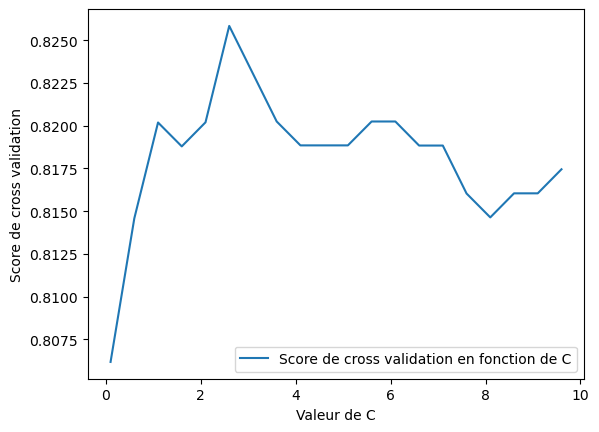

In [22]:
import matplotlib.pyplot as plt

sc1= []
for k in np.arange(0.1,10,0.5):
    Model2= SVC(kernel='rbf', C=k)
    train_val_score= cross_val_score(Model2, X_train, y_train, cv= 5).mean()
    sc1.append(train_val_score)
plt.figure()
plt.xlabel('Valeur de C')
plt.ylabel('Score de cross validation')
plt.plot(np.arange(0.1,10,0.5), sc1, label='Score de cross validation en fonction de C')
plt.legend()

On observe que d'apres le graphique la valeur optimale pour C est proche de 2.

**A l'aide de la fonction validation_curve, on va tracer le meme graphique.**

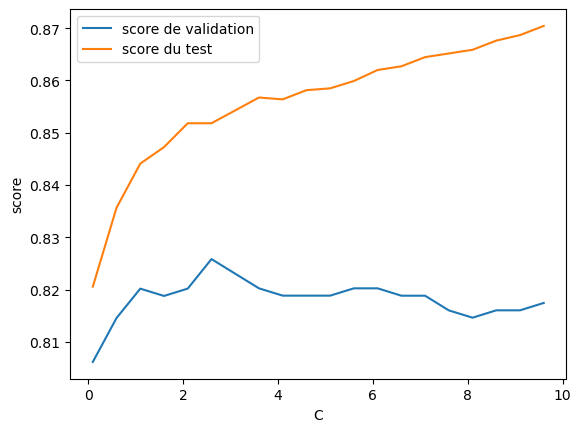

In [24]:
C= np.arange(0.1,10,0.5)
train_score, val_score= validation_curve(SVC(kernel='rbf'),X_train, y_train,param_name='C', param_range=C, cv=5)
plt.figure()
plt.plot(C, val_score.mean(axis=1), label='score de validation')
plt.plot(C, train_score.mean(axis=1), label='score du test')
plt.xlabel('C')
plt.ylabel('score')
plt.legend()
plt.show()

On constate que sur la plage des valeurs de C, il n'y a pas de surajustement

**On va ensuite faire une validation croisée sur les paramètres de régularisation C et le noyau à l'aide d'une grille afin de trouver le modèle qui a de bonnes performances sur de nouvelles données.**

In [26]:
params= {'C': np.arange(0.1,10,0.5), 'kernel':['linear', 'rbf', 'sigmoid', 'poly']}
grid= GridSearchCV(SVC(), params, cv=5)
grid.fit(X_train, y_train)
print('le meilleur modèle est: ', str(grid.best_estimator_))
print('le meilleur score est: ', str(grid.best_score_))
print('le meilleur paramètre est: ', str(grid.best_params_))

le meilleur modèle est:  SVC(C=2.6)
le meilleur score est:  0.825844577957254
le meilleur paramètre est:  {'C': 2.6, 'kernel': 'rbf'}


**Par validation croisée, le meilleur modèle est obtenu avec C=2.6 et kernel='rbf'. On va ensuite utiliser ce modèle pour obtenir le score sur le test.**


In [28]:

model1= grid.best_estimator_
y_pred= model1.predict(X_test)
test_score= accuracy_score(y_test, y_pred)
print('le score sur le test pour le nouveau modèle est: ', str(model1.score(X_test, y_test)))

le score sur le test pour le nouveau modèle est:  0.8212290502793296


In [ ]:
On obtient le meme score.

## DEUXIEME MODELE: LES FORETS ALEATOIRES

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
model2= RandomForestClassifier()
model2.fit(X_train, y_train)
model2.score(X_train, y_train)
print("le score sur les données test est : "+ str(model2.score(X_test, y_test)))

le score sur les données test est : 0.8100558659217877


Le modèle généralise moins sur de nouvelles données pour les valeurs par défaut.
On va donc procéder par une validation croisée pour trouver les paramètres sur de nouvelles données.

### Validation croisée

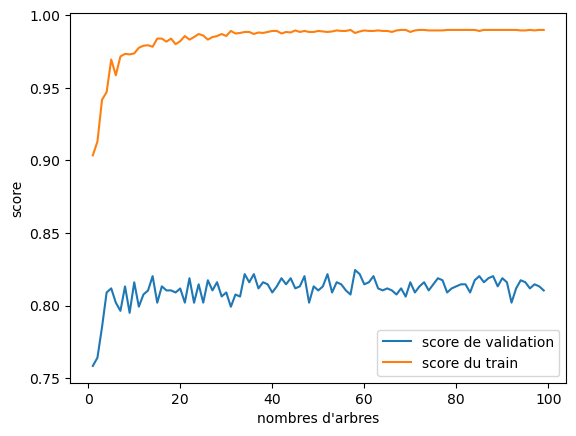

In [39]:
### Courbe de validation

param_name= 'n_estimators'
params_range= np.arange(1, 100)
train_score2, val_score2= validation_curve(RandomForestClassifier(), X_train, y_train, param_name= param_name, param_range= params_range, cv= 5 )

plt.figure()
plt.plot(params_range, val_score2.mean(axis=1), label='score de validation')
plt.plot(params_range, train_score2.mean(axis=1), label='score du train')
plt.xlabel("nombres d'arbres")
plt.ylabel('score')
plt.legend()
plt.show()


In [42]:
### GridSearchCV
params2= {'n_estimators': np.arange(1, 100) }
grid2= GridSearchCV(RandomForestClassifier(), params2, cv=5)
grid2.fit(X_train, y_train)
print(grid2.best_estimator_)
print(grid2.best_params_)
print(grid2.best_score_)

RandomForestClassifier(n_estimators=29)
{'n_estimators': 29}
0.8272431793558555


In [44]:
print("le meilleur modèle est: " +str(grid2.best_estimator_))
print("les meilleur paramètre est: " + str(grid2.best_params_))
print("le score pour le meilleur modèle sur le train est", str(grid2.best_score_))

le meilleur modèle est: RandomForestClassifier(n_estimators=29)
les meilleur paramètre est: {'n_estimators': 29}
le score pour le meilleur modèle sur le train est 0.8272431793558555


In [46]:
model2= grid2.best_estimator_
model2.fit(X_train, y_train)
print("le score sur le test pour le meilleur modèle est: ", str(model2.score(X_test, y_test)))

le score sur le test pour le meilleur modèle est:  0.7932960893854749


## TROISIEME MODELE: L'ADABOOST

Dans un premier temps, on va implémenter avec les valeurs par défaut. 
Ensuite, on va procéder à la validation croisée.

In [50]:
from sklearn.ensemble import AdaBoostClassifier

model3= AdaBoostClassifier(algorithm='SAMME')
model3.fit(X_train, y_train)
print("le score du modèle sur le train est: "+ str(model3.score(X_train, y_train)))
print("le score du modèle sur le test est: "+ str(model3.score(X_test, y_test)))

le score du modèle sur le train est: 0.8146067415730337
le score du modèle sur le test est: 0.7877094972067039


Le score obtenu sur le test n'est pas satisfaisant par rapport aux autres modèles, on va donc procéder à une validation croisée.

### Validation croisée

In [52]:
param= {'n_estimators': [50,100,150,200,250,300, 350, 400] , 'learning_rate':[0.01,0.05,0.1,0.2, 0.25, 0.3]}
grid3= GridSearchCV(model3, param_grid=param, cv=5)
grid3.fit(X_train, y_train)
print("le meilleur modèle ADABOOST est: "+ str(grid3.best_estimator_))
print("le score du meilleur modèle ADABOOST est: "+ str(grid3.best_score_))
print("les meilleurs combinaisons de paramètres du modèle ADABOOST sont: "+ str(grid3.best_params_))

le meilleur modèle ADABOOST est: AdaBoostClassifier(algorithm='SAMME', learning_rate=0.2, n_estimators=200)
le score du meilleur modèle ADABOOST est: 0.8005515611149414
les meilleurs combinaisons de paramètres du modèle ADABOOST sont: {'learning_rate': 0.2, 'n_estimators': 200}


In [54]:
model3= grid3.best_estimator_
model3.fit(X_train, y_train)
print("le score sur le test pour le meilleur modèle est: ", str(model3.score(X_test, y_test)))

le score sur le test pour le meilleur modèle est:  0.8044692737430168


## QUATRIEME MODELE: le Gradient Boosting

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

Dans un premier temps, on va implémenter avec les valeurs par défaut. 
Ensuite, on va procéder à la validation croisée.

In [58]:
model4= GradientBoostingClassifier()
model4.fit(X_train, y_train)
print("le score du modèle sur le train est: "+ str(model4.score(X_train, y_train)))
print("le score du modèle sur le test est: "+ str(model4.score(X_test, y_test)))

le score du modèle sur le train est: 0.901685393258427
le score du modèle sur le test est: 0.8156424581005587


Ce modèle est celui qui surajuste le plus par rapport aux modèles précédents.
On va donc procéder à une validation croisée.

### Validation croisée

In [60]:
param= {'n_estimators': [50,100,150,200,250,300,350,400] , 'learning_rate':[0.001,0.01,0.05,0.1,0.2]}
grid4= GridSearchCV(model4, param_grid=param, cv=5)
grid4.fit(X_train, y_train)
print("le meilleur modèle GB est: "+ str(grid4.best_estimator_))
print("le score du meilleur modèle GB est: "+ str(grid4.best_score_))
print("les meilleurs combinaisons de paramètres du modèle GB sont: "+ str(grid4.best_params_))

le meilleur modèle GB est: GradientBoostingClassifier(learning_rate=0.2)
le score du meilleur modèle GB est: 0.8216389244558258
les meilleurs combinaisons de paramètres du modèle GB sont: {'learning_rate': 0.2, 'n_estimators': 100}


In [62]:
model4= grid4.best_estimator_
model4.fit(X_train, y_train)
print("le score sur le test pour le meilleur modèle est: ", str(model4.score(X_test, y_test)))

le score sur le test pour le meilleur modèle est:  0.7988826815642458


In [223]:
import sys
print(sys.version)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [143]:
modele_final= make_pipeline(transformer, grid.best_estimator_)
#modele_final(X_train, ytrain)
joblib.dump(modele_final, 'model_svm.joblib')
joblib.dump(transformer, 'transformation.joblib')
joblib.dump(np.unique(titanic_train['Embarked'].fillna(' ', inplace=False).values), 'titanic_train.joblib')

['titanic_train.joblib']

In [133]:
#modele_final.score(X_train, y_train)